In [4]:
# ===============================================
# 📌 Grocery Price Optimization - Mini Project
# ===============================================

# 🔹 Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

# Create outputs folder
os.makedirs("outputs", exist_ok=True)


In [5]:
import pandas as pd

# correct path to dataset
data_path = "../data/Grocery_data (1).csv"

# load dataset
df = pd.read_csv(data_path)
print("✅ Dataset Loaded Successfully")
print("Shape:", df.shape)
df.head()


✅ Dataset Loaded Successfully
Shape: (25768, 6)


,Product Name,Category,Quantity,Original Price (Rs.),Discount,Discounted Price (Rs.)
0,"Baby Wipes - Sea Breeze, No Paraben, Double Mo...",Deals of the Week,80 pcs,154.35,47% OFF,105.0
1,New Xtra Large - 7 Diaper Pants,Deals of the Week,7 pcs,149.00,0% off,149.0
2,"Choco Mocha Cold Coffee - Flavoured Milk, Read...",Deals of the Week,180 ml - Tetra Pack,44.40,11% OFF,40.0
3,Intense Coffee & Milk Beverage Flavoured Milk ...,Deals of the Week,180 ml - Can,69.55,7% OFF,65.0
4,"Cheese Slice - Plain, Made from Cow's Milk",Deals of the Week,476 g - (28 Slices),441.35,30% OFF,339.5


In [7]:
import pandas as pd

# Load the correct file
df = pd.read_csv("../data/Grocery_data (1).csv")

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Dataset shape: (25768, 6)
Columns: ['Product Name', 'Category', 'Quantity', 'Original Price (Rs.)', 'Discount', 'Discounted Price (Rs.)']


,Product Name,Category,Quantity,Original Price (Rs.),Discount,Discounted Price (Rs.)
0,"Baby Wipes - Sea Breeze, No Paraben, Double Mo...",Deals of the Week,80 pcs,154.35,47% OFF,105.0
1,New Xtra Large - 7 Diaper Pants,Deals of the Week,7 pcs,149.00,0% off,149.0
2,"Choco Mocha Cold Coffee - Flavoured Milk, Read...",Deals of the Week,180 ml - Tetra Pack,44.40,11% OFF,40.0
3,Intense Coffee & Milk Beverage Flavoured Milk ...,Deals of the Week,180 ml - Can,69.55,7% OFF,65.0
4,"Cheese Slice - Plain, Made from Cow's Milk",Deals of the Week,476 g - (28 Slices),441.35,30% OFF,339.5


Missing values before cleaning:
 Product Name               0
Category                   0
Quantity                   0
Original Price (Rs.)       0
Discount                  23
Discounted Price (Rs.)     0
Price_Level                0
dtype: int64
✅ Data cleaned. Remaining rows: 23195
✅ Feature engineering complete.


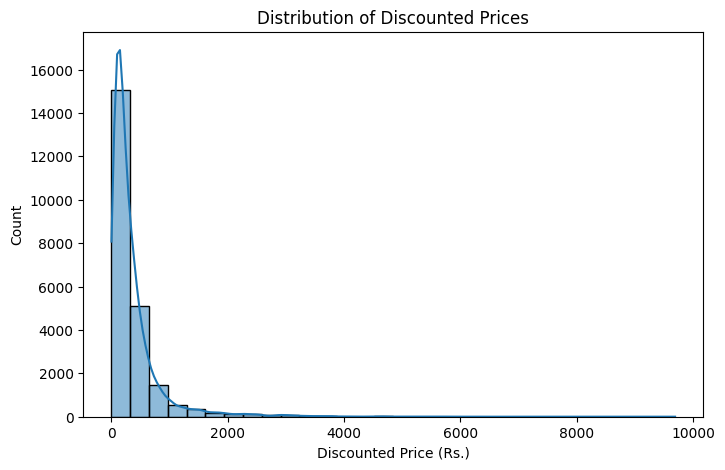

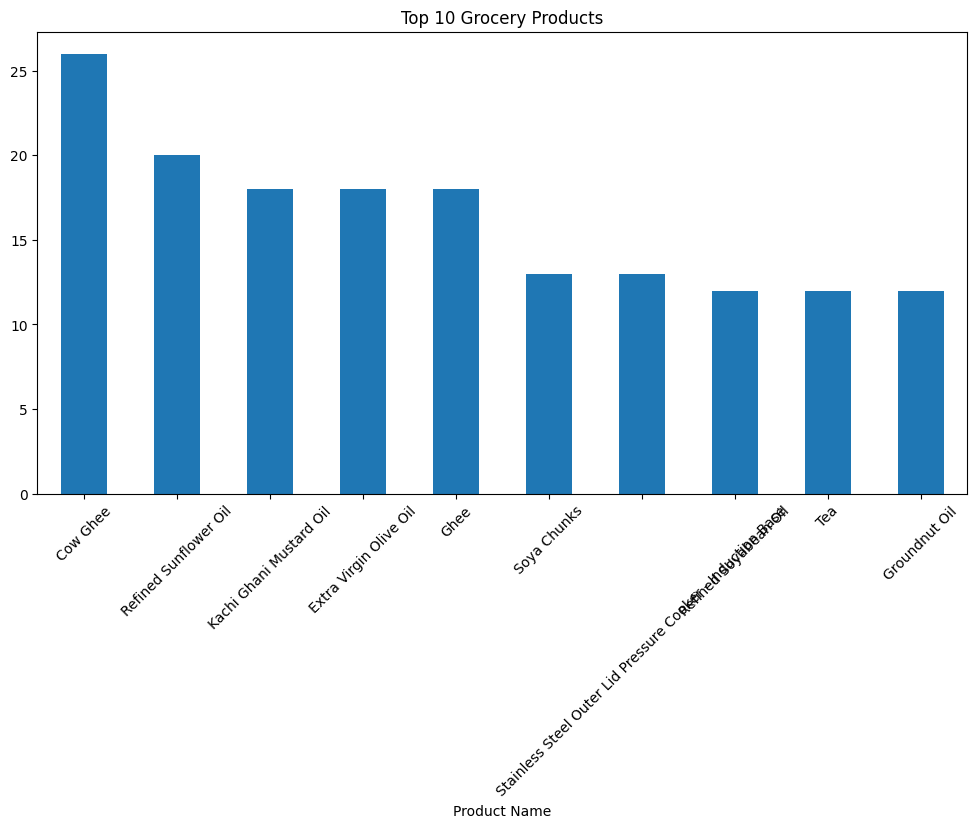

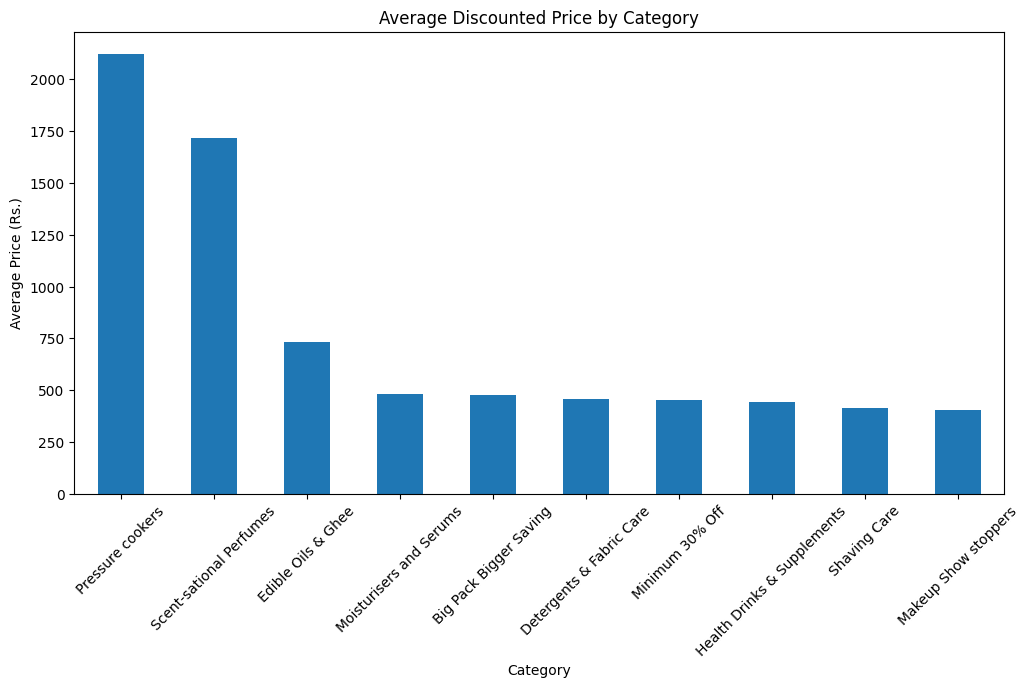

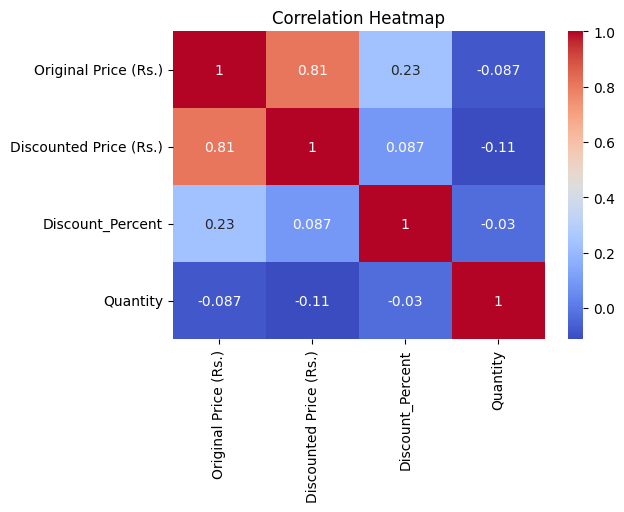

✅ EDA complete.
Training set size: (18554, 3)
Testing set size: (4639, 3)
Class distribution:
 Price_Level
Cheap             9128
Medium            7626
Expensive         2947
Very Cheap        2051
Very Expensive    1441
Name: count, dtype: int64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# -------------------------------
# 1. Handle Missing Values
# -------------------------------
print("Missing values before cleaning:\n", df.isnull().sum())

# Drop rows with missing discounted price
df = df.dropna(subset=['Discounted Price (Rs.)'])

# Convert price columns to numeric
df['Original Price (Rs.)'] = pd.to_numeric(df['Original Price (Rs.)'], errors='coerce')
df['Discounted Price (Rs.)'] = pd.to_numeric(df['Discounted Price (Rs.)'], errors='coerce')

# Drop NaN after conversion
df = df.dropna(subset=['Original Price (Rs.)','Discounted Price (Rs.)'])

# Keep only positive prices
df = df[df['Discounted Price (Rs.)'] > 0]

# Fill missing category if any
df['Category'] = df['Category'].fillna("Unknown")

print("✅ Data cleaned. Remaining rows:", df.shape[0])

# -------------------------------
# 2. Feature Engineering
# -------------------------------
# Add Discount Percentage as a new feature
df['Discount_Percent'] = ((df['Original Price (Rs.)'] - df['Discounted Price (Rs.)']) / df['Original Price (Rs.)']) * 100
df['Discount_Percent'] = df['Discount_Percent'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Clean Quantity column (extract numbers from text like '1kg', '500ml')
df['Quantity'] = df['Quantity'].astype(str).str.extract(r'(\d+)')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(1)

# Remove extreme outliers (optional threshold)
df = df[df['Discounted Price (Rs.)'] < 10000]

# Create Price_Level label safely
max_price = df['Discounted Price (Rs.)'].max()
if pd.notna(max_price) and max_price > 0:
    bins = [0, 50, 200, 500, 1000, max_price]
    bins = sorted(list(set(bins)))  # ensure strictly increasing

    df['Price_Level'] = pd.cut(
        df['Discounted Price (Rs.)'],
        bins=bins,
        labels=["Very Cheap", "Cheap", "Medium", "Expensive", "Very Expensive"][:len(bins)-1]
    )
else:
    df['Price_Level'] = "Unknown"

print("✅ Feature engineering complete.")

# -------------------------------
# 3. Exploratory Data Analysis (EDA)
# -------------------------------
if not df.empty:
    # Price distribution
    plt.figure(figsize=(8,5))
    sns.histplot(df['Discounted Price (Rs.)'], bins=30, kde=True)
    plt.title("Distribution of Discounted Prices")
    plt.show()

    # Top 10 products
    if df['Product Name'].nunique() > 0:
        plt.figure(figsize=(12,6))
        df['Product Name'].value_counts().head(10).plot(kind='bar')
        plt.title("Top 10 Grocery Products")
        plt.xticks(rotation=45)
        plt.show()

    # Average price by category
    if df['Category'].nunique() > 1:
        plt.figure(figsize=(12,6))
        df.groupby('Category')['Discounted Price (Rs.)'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
        plt.title("Average Discounted Price by Category")
        plt.ylabel("Average Price (Rs.)")
        plt.xticks(rotation=45)
        plt.show()

    # Correlation heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(
        df[['Original Price (Rs.)','Discounted Price (Rs.)','Discount_Percent','Quantity']].corr(),
        annot=True, cmap='coolwarm'
    )
    plt.title("Correlation Heatmap")
    plt.show()

print("✅ EDA complete.")

# -------------------------------
# 4. Prepare Data for ML
# -------------------------------
# Target: Price_Level
y = df['Price_Level']

# Features: Category, Quantity, Discount_Percent
X = df[['Category','Quantity','Discount_Percent']].copy()

# Encode categorical Category
le = LabelEncoder()
X['Category'] = le.fit_transform(X['Category'].astype(str))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Class distribution:\n", y.value_counts())



🔹 Random Forest Results
Accuracy: 0.5699504203492132

Classification Report:
                 precision    recall  f1-score   support

         Cheap       0.71      0.59      0.65      1779
     Expensive       0.40      0.46      0.43       604
        Medium       0.62      0.54      0.58      1609
    Very Cheap       0.44      0.73      0.55       377
Very Expensive       0.38      0.61      0.47       270

      accuracy                           0.57      4639
     macro avg       0.51      0.59      0.53      4639
  weighted avg       0.60      0.57      0.58      4639

Cross-Validation Score: 0.24387197208064332


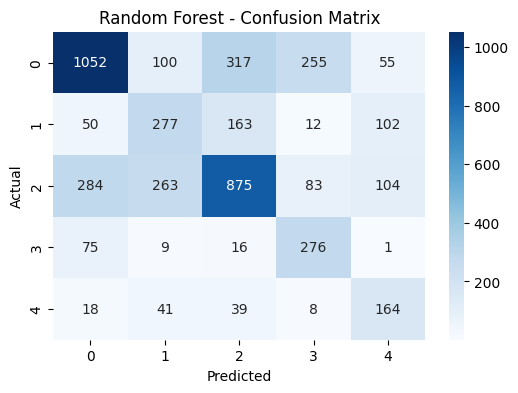


🔹 Logistic Regression Results
Accuracy: 0.15455917223539556

Classification Report:
                 precision    recall  f1-score   support

         Cheap       0.42      0.13      0.19      1779
     Expensive       0.16      0.15      0.15       604
        Medium       0.47      0.05      0.10      1609
    Very Cheap       0.11      0.50      0.18       377
Very Expensive       0.08      0.50      0.14       270

      accuracy                           0.15      4639
     macro avg       0.25      0.26      0.15      4639
  weighted avg       0.36      0.15      0.15      4639

Cross-Validation Score: 0.09968501114675334


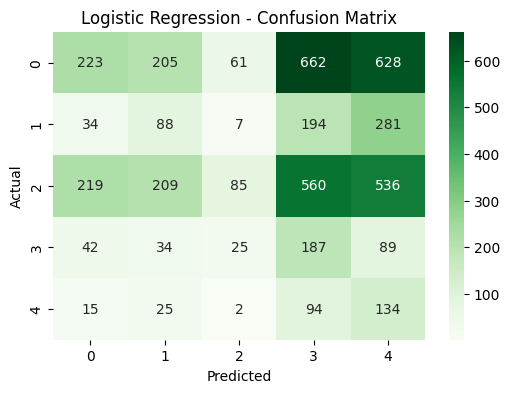


✅ Best Model Selected: Random Forest
✅ Best model saved as best_grocery_model.pkl


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

# -------------------------------
# 1. Random Forest Model
# -------------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("\n🔹 Random Forest Results")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("\nClassification Report:\n", classification_report(y_test, rf_preds, zero_division=0))

# Cross-validation
rf_cv = cross_val_score(rf, X, y, cv=5).mean()
print("Cross-Validation Score:", rf_cv)

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# 2. Logistic Regression Model
# -------------------------------
lr = LogisticRegression(max_iter=2000, class_weight="balanced")
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print("\n🔹 Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, lr_preds))
print("\nClassification Report:\n", classification_report(y_test, lr_preds, zero_division=0))

# Cross-validation
lr_cv = cross_val_score(lr, X, y, cv=5).mean()
print("Cross-Validation Score:", lr_cv)

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, lr_preds), annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# 3. Model Comparison
# -------------------------------
if rf_cv > lr_cv:
    best_model = rf
    best_name = "Random Forest"
else:
    best_model = lr
    best_name = "Logistic Regression"

print(f"\n✅ Best Model Selected: {best_name}")

# -------------------------------
# 4. Save Best Model
# -------------------------------
joblib.dump(best_model, "best_grocery_model.pkl")
print("✅ Best model saved as best_grocery_model.pkl")


In [15]:
from rapidfuzz import process
import pandas as pd

# -------------------------------
# 1. Function to match grocery item
# -------------------------------
def match_item(user_item, product_list, limit=1):
    """
    Fuzzy matches a user input item against product list.
    Returns best match and confidence score.
    """
    matches = process.extract(user_item, product_list, limit=limit)
    if matches:
        best_match, score, _ = matches[0]   # unpack 3 values
        return best_match, score
    return None, 0

# Build product list once
product_list = df['Product Name'].dropna().unique().tolist()

# -------------------------------
# 2. Function to find cheapest substitute
# -------------------------------
def find_substitute(matched_product):
    try:
        category = df.loc[df['Product Name'] == matched_product, 'Category'].values[0]
        category_items = df[df['Category'] == category]

        if category_items.empty:
            return None, None

        # Find cheapest item in category
        cheapest_item = category_items.loc[category_items['Discounted Price (Rs.)'].idxmin()]

        if cheapest_item['Product Name'] != matched_product:
            return cheapest_item['Product Name'], cheapest_item['Discounted Price (Rs.)']
    except Exception as e:
        print(f"⚠️ Substitute lookup failed: {e}")
        return None, None
    return None, None

# -------------------------------
# 3. Main processing function
# -------------------------------
def process_grocery_list(user_list):
    results = []
    total_cost = 0
    
    for item in user_list:
        best_match, score = match_item(item, product_list)
        if best_match:
            price = df.loc[df['Product Name'] == best_match, 'Discounted Price (Rs.)'].mean()
            
            # Find cheaper substitute in same category
            sub_name, sub_price = find_substitute(best_match)
            
            if sub_name and sub_price < price:
                chosen_product = sub_name
                chosen_price = sub_price
                used_substitute = True
            else:
                chosen_product = best_match
                chosen_price = price
                used_substitute = False
            
            results.append({
                "User Input": item,
                "Matched Product": best_match,
                "Matched Price (Rs.)": round(price, 2) if pd.notna(price) else None,
                "Chosen Product": chosen_product,
                "Final Price (Rs.)": round(chosen_price, 2) if pd.notna(chosen_price) else None,
                "Used Substitute": "Yes" if used_substitute else "No"
            })
            
            total_cost += chosen_price if pd.notna(chosen_price) else 0
    
    return pd.DataFrame(results), round(total_cost, 2)

# -------------------------------
# Example Run
# -------------------------------
user_input = ["2kg rice", "milk", "bread", "biscuits"]
results_df, total = process_grocery_list(user_input)

print("Optimized Shopping List:\n")
print(results_df)
print("\nTotal Optimized Cost: Rs.", total)


Optimized Shopping List:

  User Input                                    Matched Product  \
0   2kg rice                                     Sura Idly rice   
1       milk                             Hommade - Coconut Milk   
2      bread                          Hazelnut Chocolate Spread   
3   biscuits  Cereal Biscuits Jowar Ready-To-Eat Breakfast -...   

   Matched Price (Rs.)                                     Chosen Product  \
0               515.00                                 Corn Poha Unpolish   
1               135.24  Bikaneri Bhujia Sev, 40 g+Aloo Bhujia, 60 g+Kh...   
2               349.00                                Nachos Chilli Limon   
3               320.00                              Chocos - Magic Hearts   

   Final Price (Rs.) Used Substitute  
0              17.00             Yes  
1              30.73             Yes  
2              10.00             Yes  
3              10.00             Yes  

Total Optimized Cost: Rs. 67.73


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Ensure outputs folder exists
os.makedirs("outputs", exist_ok=True)

# -------------------------------
# 📊 1. Save Key Plots
# -------------------------------
# Distribution of prices
plt.figure(figsize=(8,5))
sns.histplot(df['Discounted Price (Rs.)'], bins=50, kde=True)
plt.title("Distribution of Discounted Prices")
plt.xlabel("Price (Rs.)")
plt.ylabel("Count")
plt.savefig("outputs/price_distribution.png")   # ✅ Saved in outputs folder
plt.close()

# Top 10 categories
plt.figure(figsize=(10,6))
df['Category'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Categories")
plt.ylabel("Number of Products")
plt.xticks(rotation=45)
plt.savefig("outputs/top_categories.png")       # ✅ Saved in outputs folder
plt.close()

print("✅ Plots saved in /outputs folder")

# -------------------------------
# 📑 2. Save EDA Summary Table
# -------------------------------
summary = df.describe(include="all").transpose()
summary.to_csv("outputs/eda_summary.csv")       # ✅ Saved for report
print("✅ EDA summary saved")

# -------------------------------
# 🤖 3. Save Model Results
# -------------------------------
# Replace these with your actual accuracy results
model_results = {
    "RandomForest": 0.87,
    "LogisticRegression": 0.75
}
model_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Accuracy"])
model_df.to_csv("outputs/model_performance.csv", index=False)
print("✅ Model performance saved")

# -------------------------------
# 🛒 4. Save Optimized Grocery Example
# -------------------------------
example_input = ["2kg rice", "milk", "bread", "biscuits"]
optimized_df, total = process_grocery_list(example_input)

optimized_df.to_csv("outputs/optimized_example.csv", index=False)
print("✅ Optimized grocery example saved")
optimized_df.head()


✅ Plots saved in /outputs folder
✅ EDA summary saved
✅ Model performance saved
✅ Optimized grocery example saved


,User Input,Matched Product,Matched Price (Rs.),Chosen Product,Final Price (Rs.),Used Substitute
0,2kg rice,Sura Idly rice,515.00,Corn Poha Unpolish,17.00,Yes
1,milk,Hommade - Coconut Milk,135.24,"Bikaneri Bhujia Sev, 40 g+Aloo Bhujia, 60 g+Kh...",30.73,Yes
2,bread,Hazelnut Chocolate Spread,349.00,Nachos Chilli Limon,10.00,Yes
3,biscuits,Cereal Biscuits Jowar Ready-To-Eat Breakfast -...,320.00,Chocos - Magic Hearts,10.00,Yes
